# Reanalyzing dataset from Neftel, Laffy, et al. 2019

I will be reanalyzing the dataset from [An Integrative Model of Cellular States, Plasticity, and Genetics for Glioblastoma, a paper by Neftel, Laffy, et al. from 2019.](https://www.cell.com/cell/fulltext/S0092-8674(19)30687-7) This paper explores samples from 28 glioblastomas and concludes that there are four cellular states driving heterogeneity in glioblastoma malignant cells.

In Part 1, this notebook, I will be attempting to normalize, perform quality control, and identify the malignant cells.

In [Part 2](./Part2_ExploringMalignantCells.ipynb), I will be exploring the malignant cells, using the meta-modules defined in the Neftel et al. paper to identify cells by subtype, and then assigning hybridization status to each cell. I will also be visualizing each of these steps and ensuring my findings are similar to those from the original paper.

## Identifying high-quality, malignant cells

We begin with the standard import of `scanpy` and settings changes. Then we will attempt to reanalyze the data, both exploring new facets and highlighting potential issues or areas where clarification could have been used in the original paper.

In [1]:
import scanpy as sc

sc.settings.verbosity = 0
sc.set_figure_params(dpi=150, figsize=(3, 3), frameon=False)

### Reading in data

We are going to begin reading in the SMART-Seq2 data file, `GSM3828672_Smartseq2_GBM_IDHwt_processed_TPM.tsv`, from the Neftel, Laffy, et al. 2019 study. The expression matrix must be transposed, so that the observations are the cell barcodes and the variables are the read counts. We will see that there are 7930 cells and 23686 genes in the dataset.

In [2]:
adata_pre = sc.read("GSM3828672_Smartseq2_GBM_IDHwt_processed_TPM.tsv")
adata = adata_pre.transpose()
del adata_pre
adata

AnnData object with n_obs × n_vars = 7930 × 23686

### Quality control

My original plan was to try to start from the raw data and then preform QC as they did, and according to the SC best practices book. But I cannot do this, because the file they provided is already filtered and normalized. Additionally, they did not perform a few quality control steps during the original process; namely, ambient RNA correction and doublet detection. I would love to see how those steps would have affected the results, but since I do not have access to the raw data, I am unable to do so.

### Dimensionality reduction

We will thus proceed with dimensionality reduction, going through the steps from the SC best practices book and comparing to what the authors did in the original study, to the best of my ability. We will start with calculating the QC metrics and plotting the cells using PCA, tSNE, and UMAP.

In [3]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

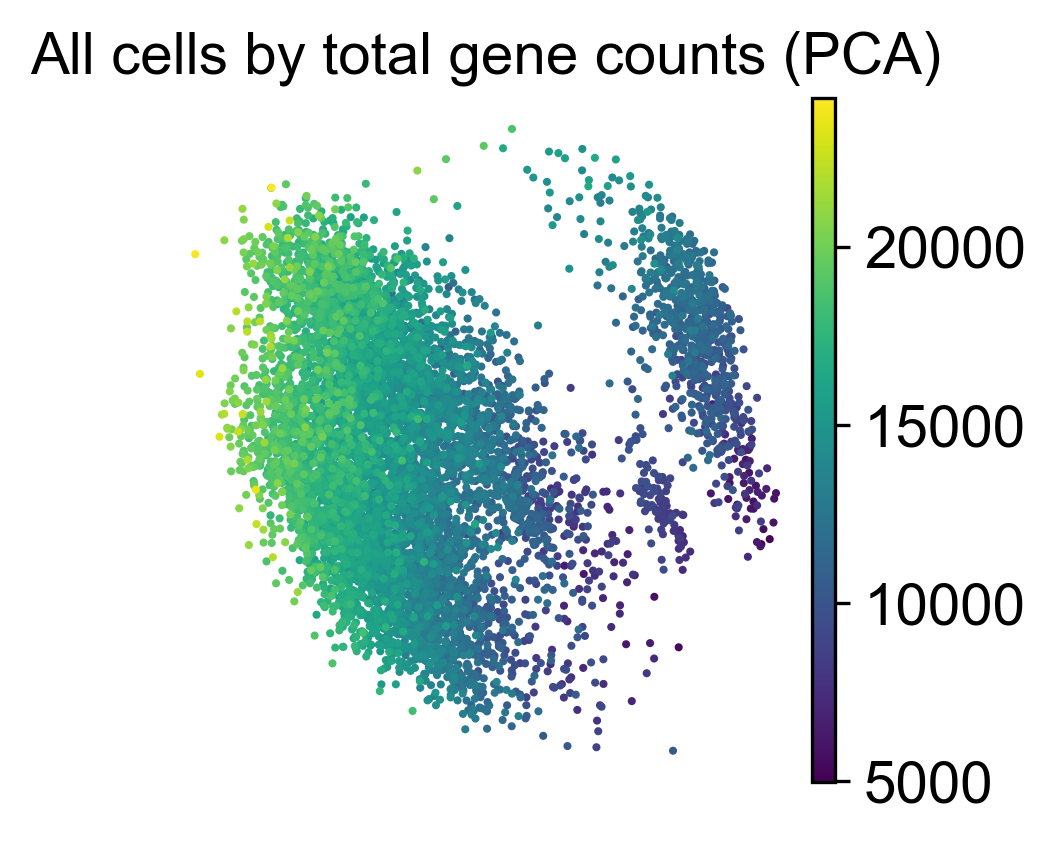

In [4]:
sc.pp.pca(adata, svd_solver="arpack")
sc.pl.pca_scatter(adata, color="total_counts", title="All cells by total gene counts (PCA)")

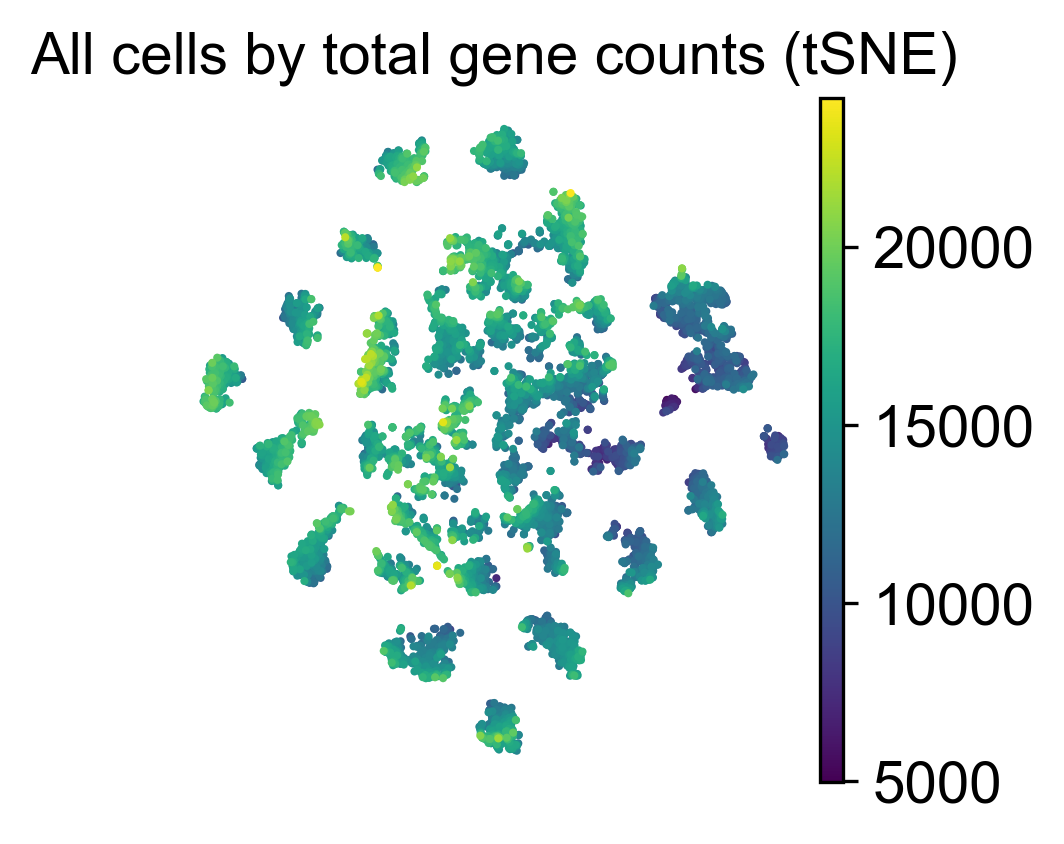

In [5]:
sc.tl.tsne(adata, use_rep="X_pca")
sc.pl.tsne(adata, color="total_counts", title="All cells by total gene counts (tSNE)")

C:\Users\Andrew\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


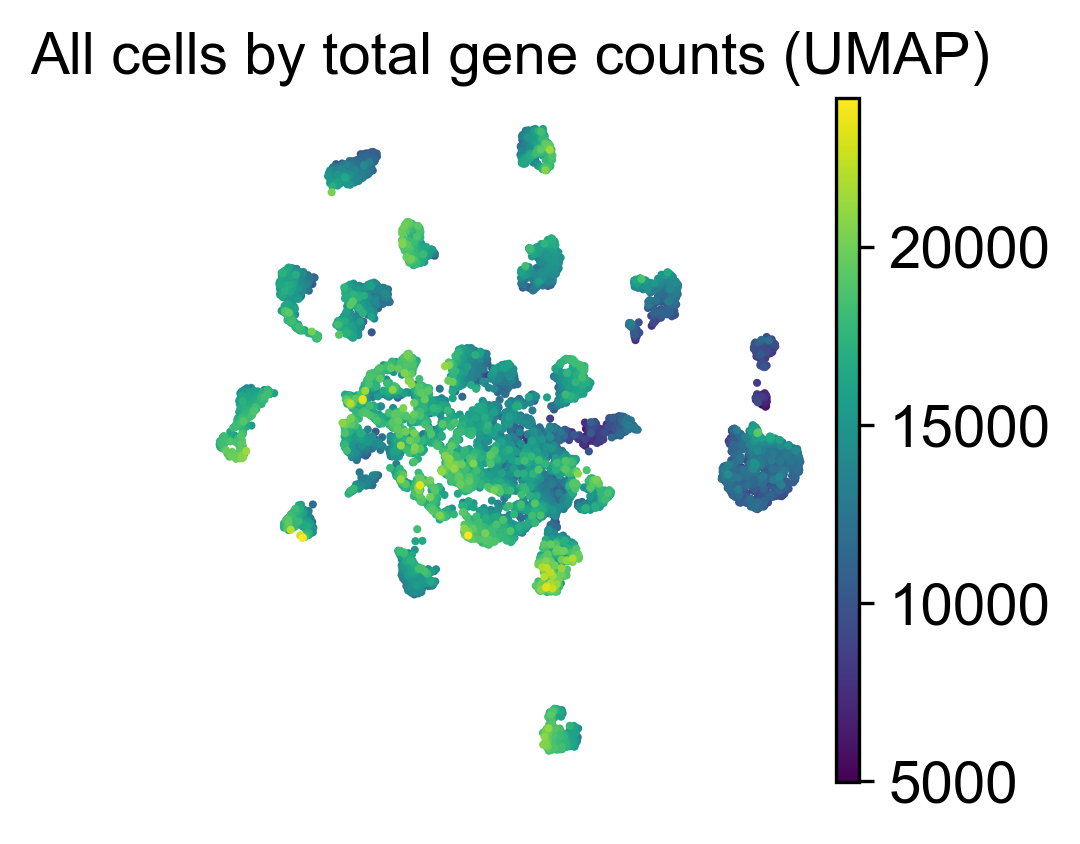

In [6]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="total_counts", title="All cells by total gene counts (UMAP)")

The total counts don't seem particularly noteworthy. But coloring the cells by their origin tumor shows that cells are clustered very clearly based on that.

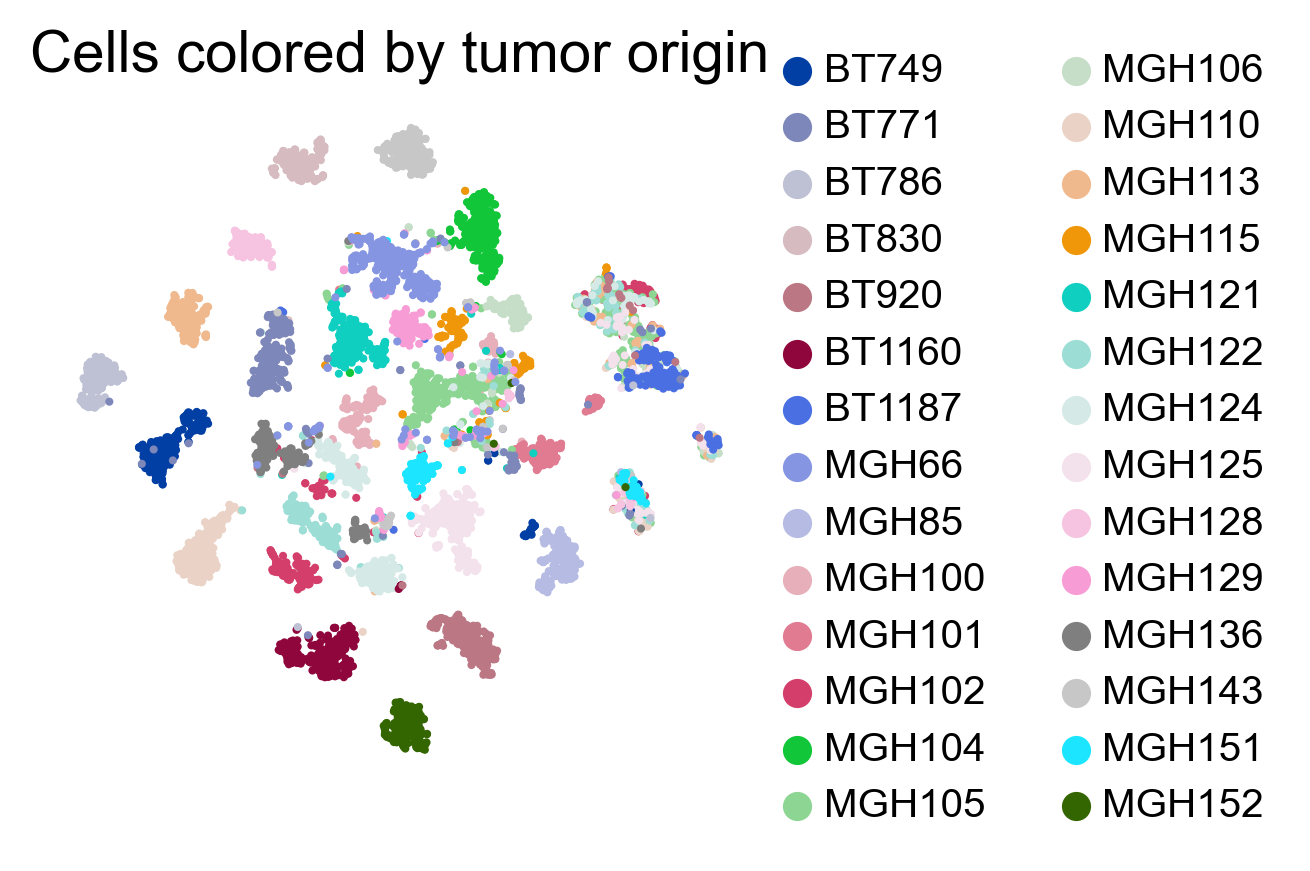

In [7]:
adata.obs["origin"] = adata.obs_names.str.findall(r'([A-Z+]+\d+)\S*-').str[0]
sc.pl.tsne(adata, color="origin", title="Cells colored by tumor origin", legend_fontsize="x-small")

### Identifying and removing non-malignant cells

The paper, using the default MATLAB `tsne` parameters, calculated tsne without using PCs. This led to an extremely coarse clustering, showing the three non-malignant cell types they identified as unique clusters, with the remaining malignant cells clustering together. In our more complex tsne here, we can see the three clusters as well, but it is hard to distinguish them right away. I will now use the marker genes indicated in the paper to indicate where the macrophages, T-cells, and oligodendrocytes cluster together.

In order to further explore the dataset, we will also look at genes found to be differentially expressed in glioblastomas. A [paper from 2022 by Li et al.](https://www.frontiersin.org/journals/genetics/articles/10.3389/fgene.2022.832742/full) listed several in a table, which is what I used.

MACROPHAGES:


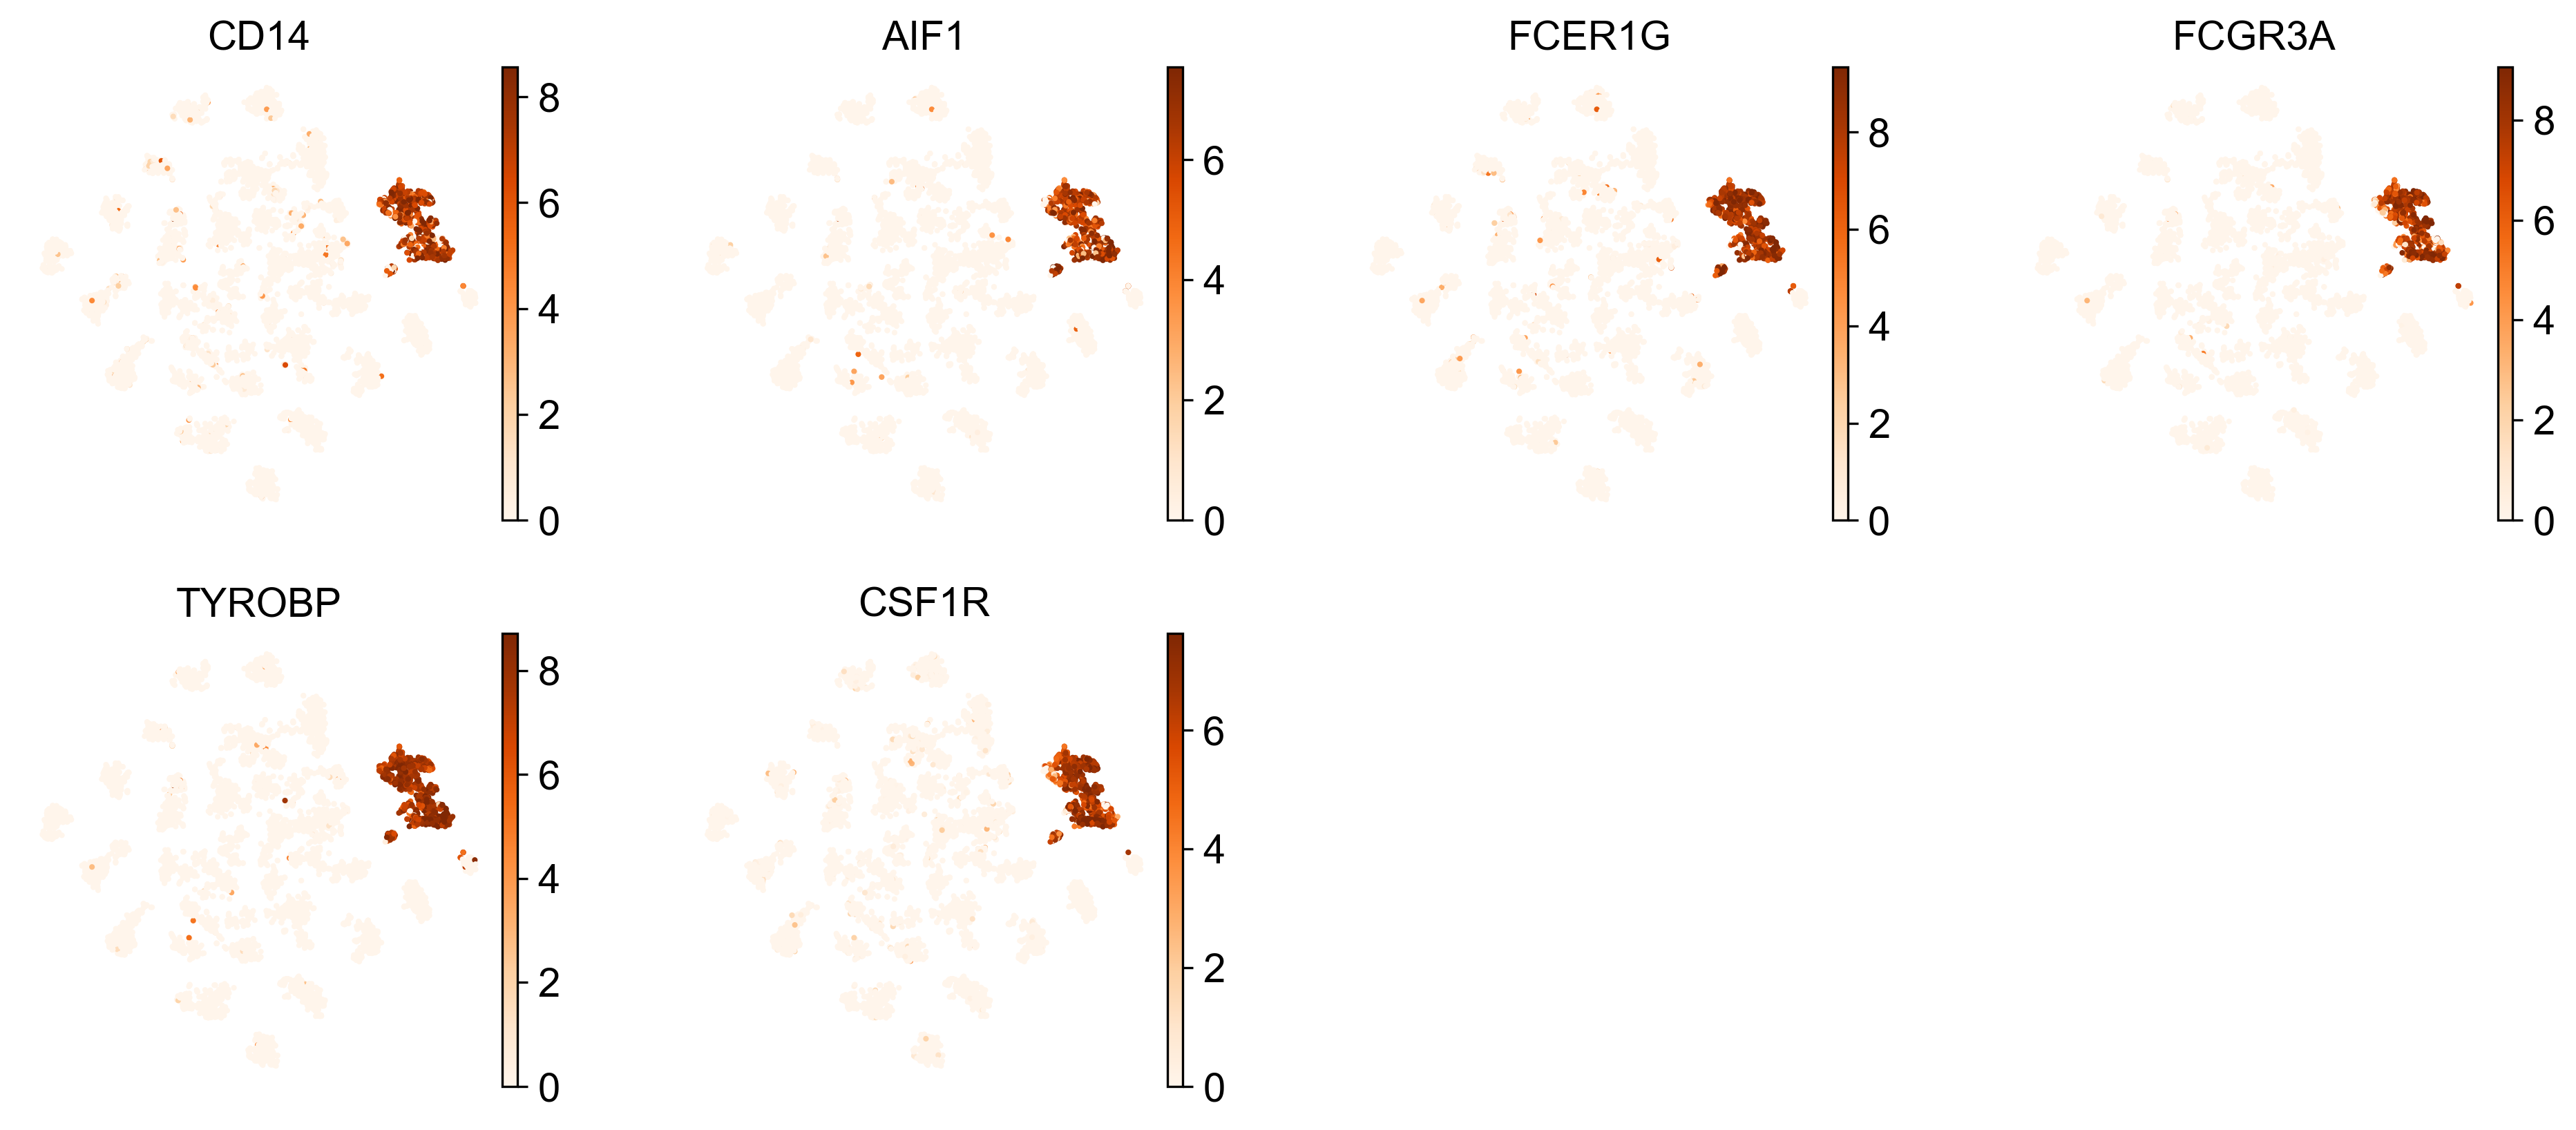





T CELLS:


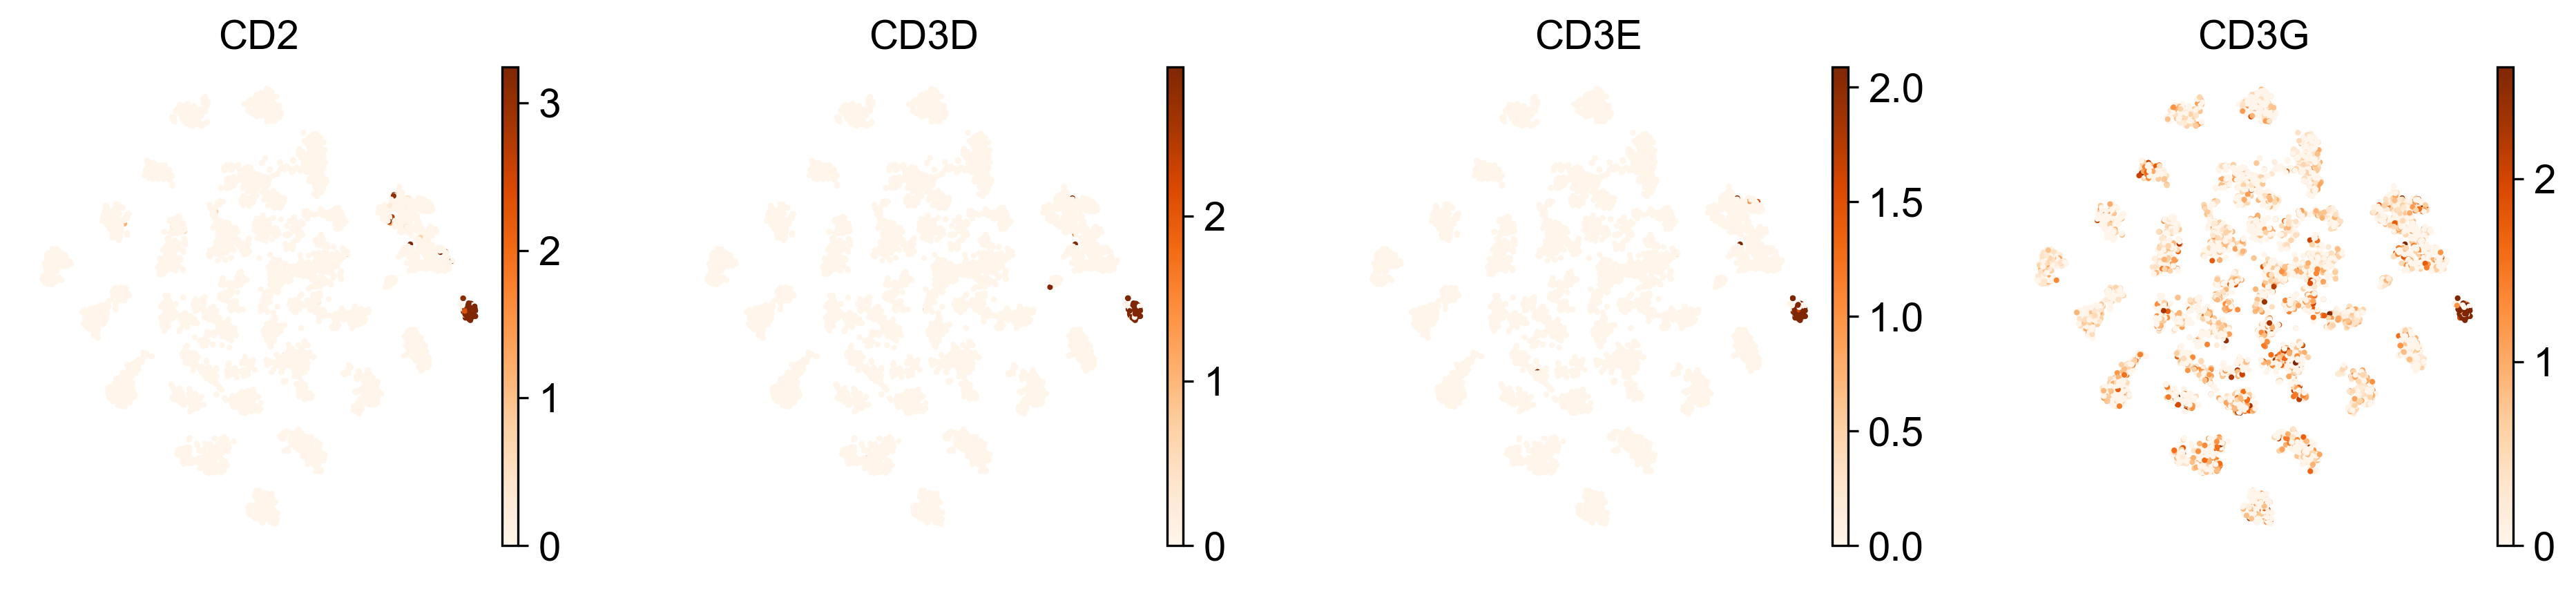





OLIGODENDROCYTES:


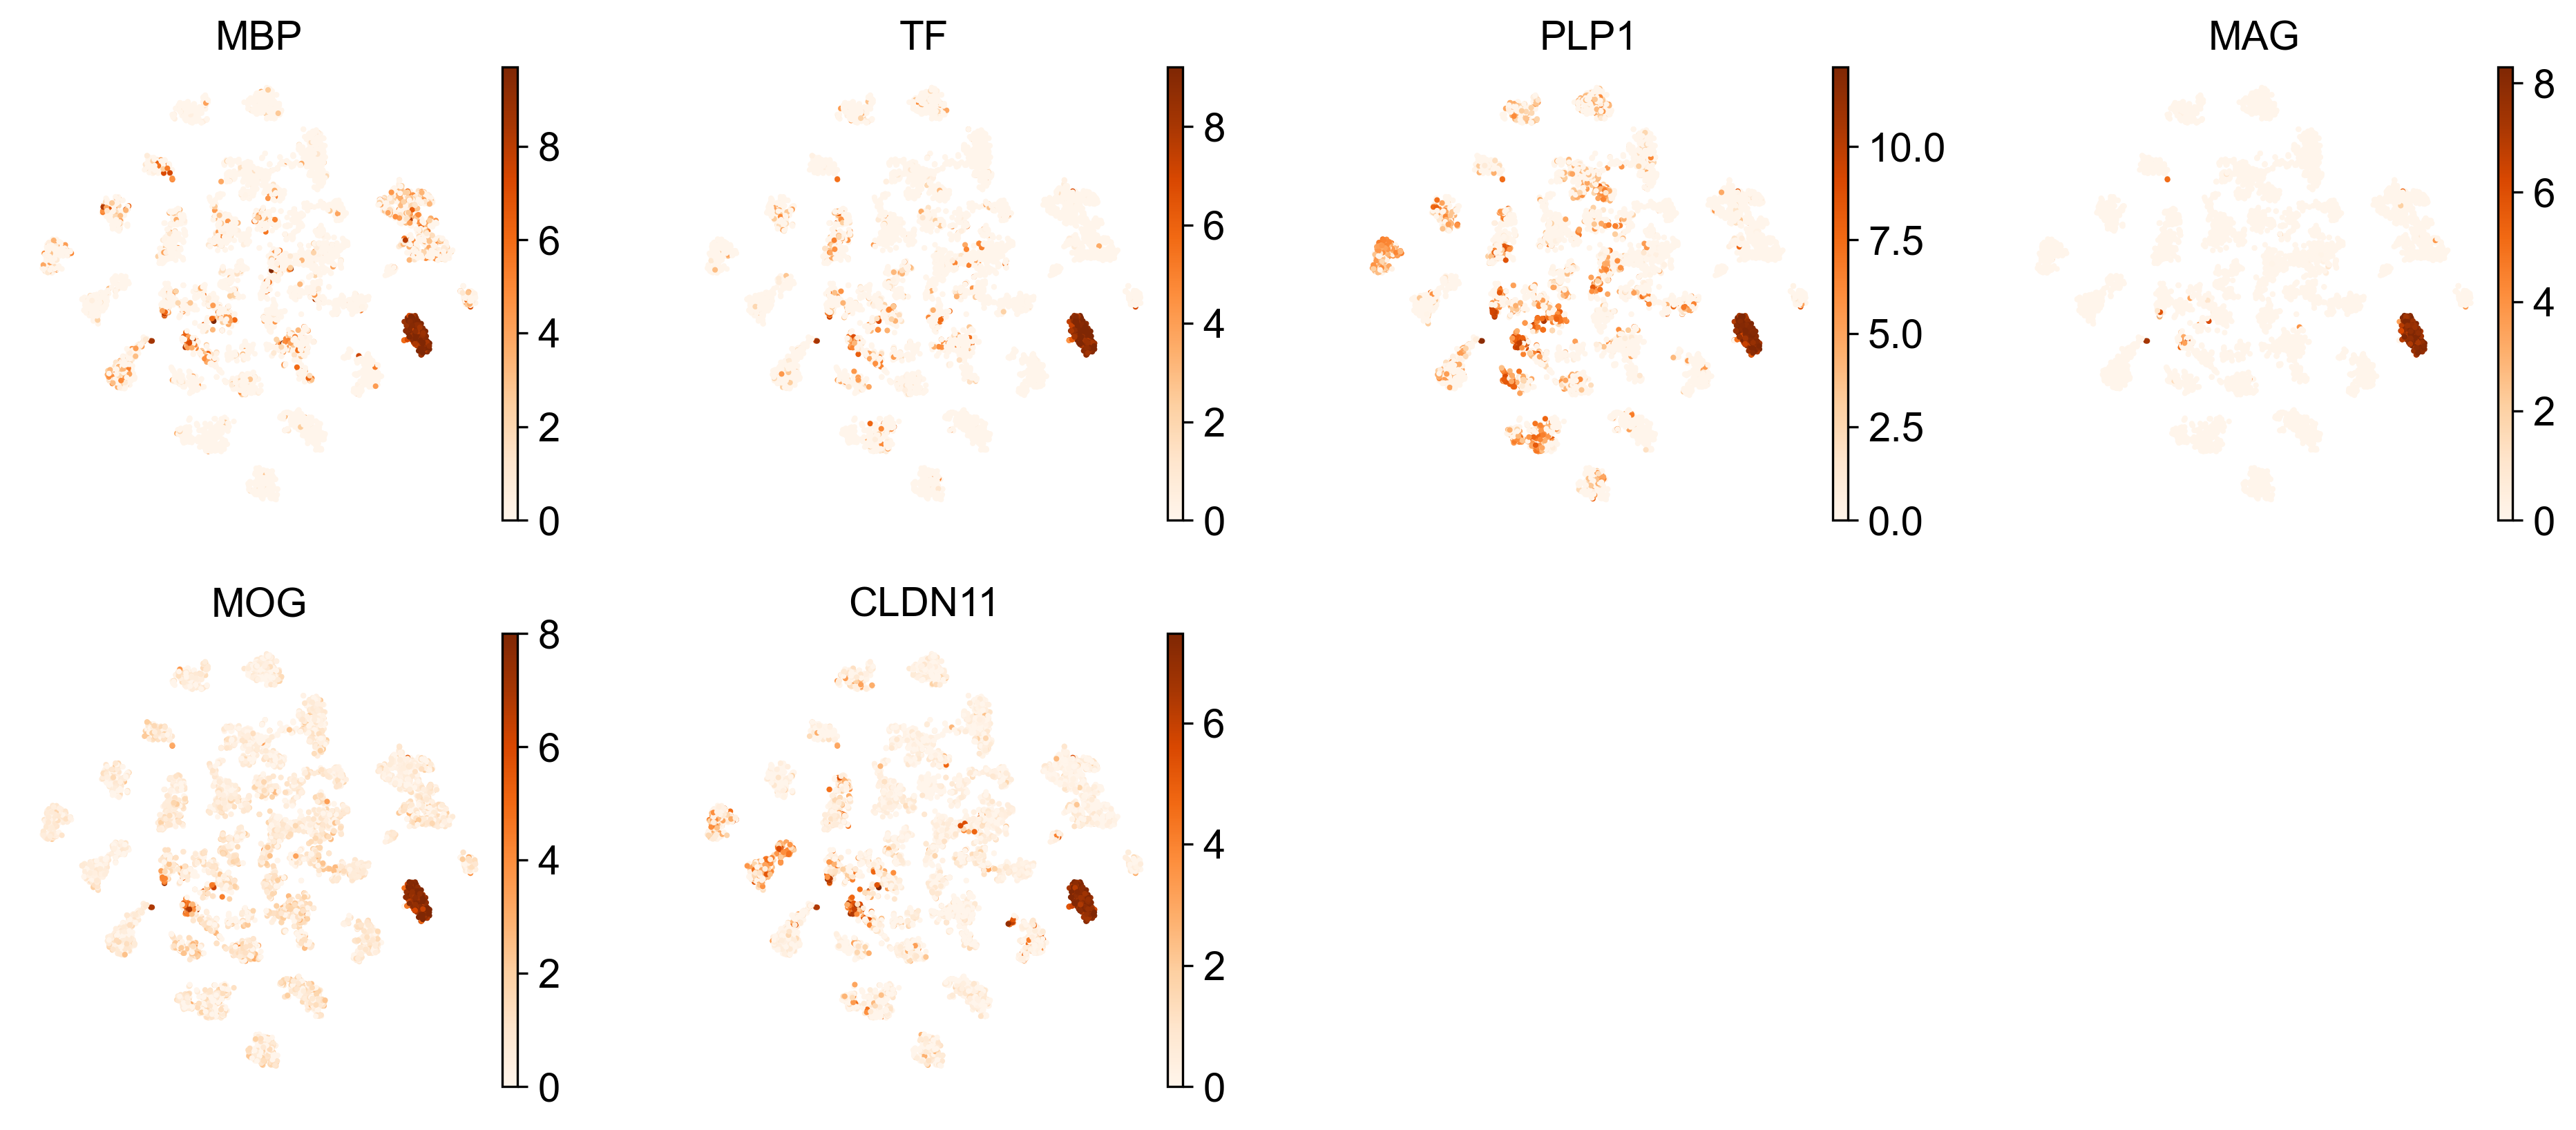

In [8]:
marker_genes = {
    "Macrophage": ["CD14", "AIF1", "FCER1G", "FCGR3A", "TYROBP", "CSF1R" ],
    "T cell": ["CD2", "CD3D", "CD3E", "CD3G"],
    "Oligodendrocyte": ["MBP", "TF", "PLP1", "MAG", "MOG", "CLDN11"]
}

for ct in marker_genes:
    print(f"{ct.upper()}S:")  # print cell subtype name
    sc.pl.tsne(
        adata,
        color=marker_genes[ct],
        vmin=0,
        vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="Oranges",
    )
    print("\n\n\n")  # print white space for legibility



GLIOBLASTOMA POSITIVE:


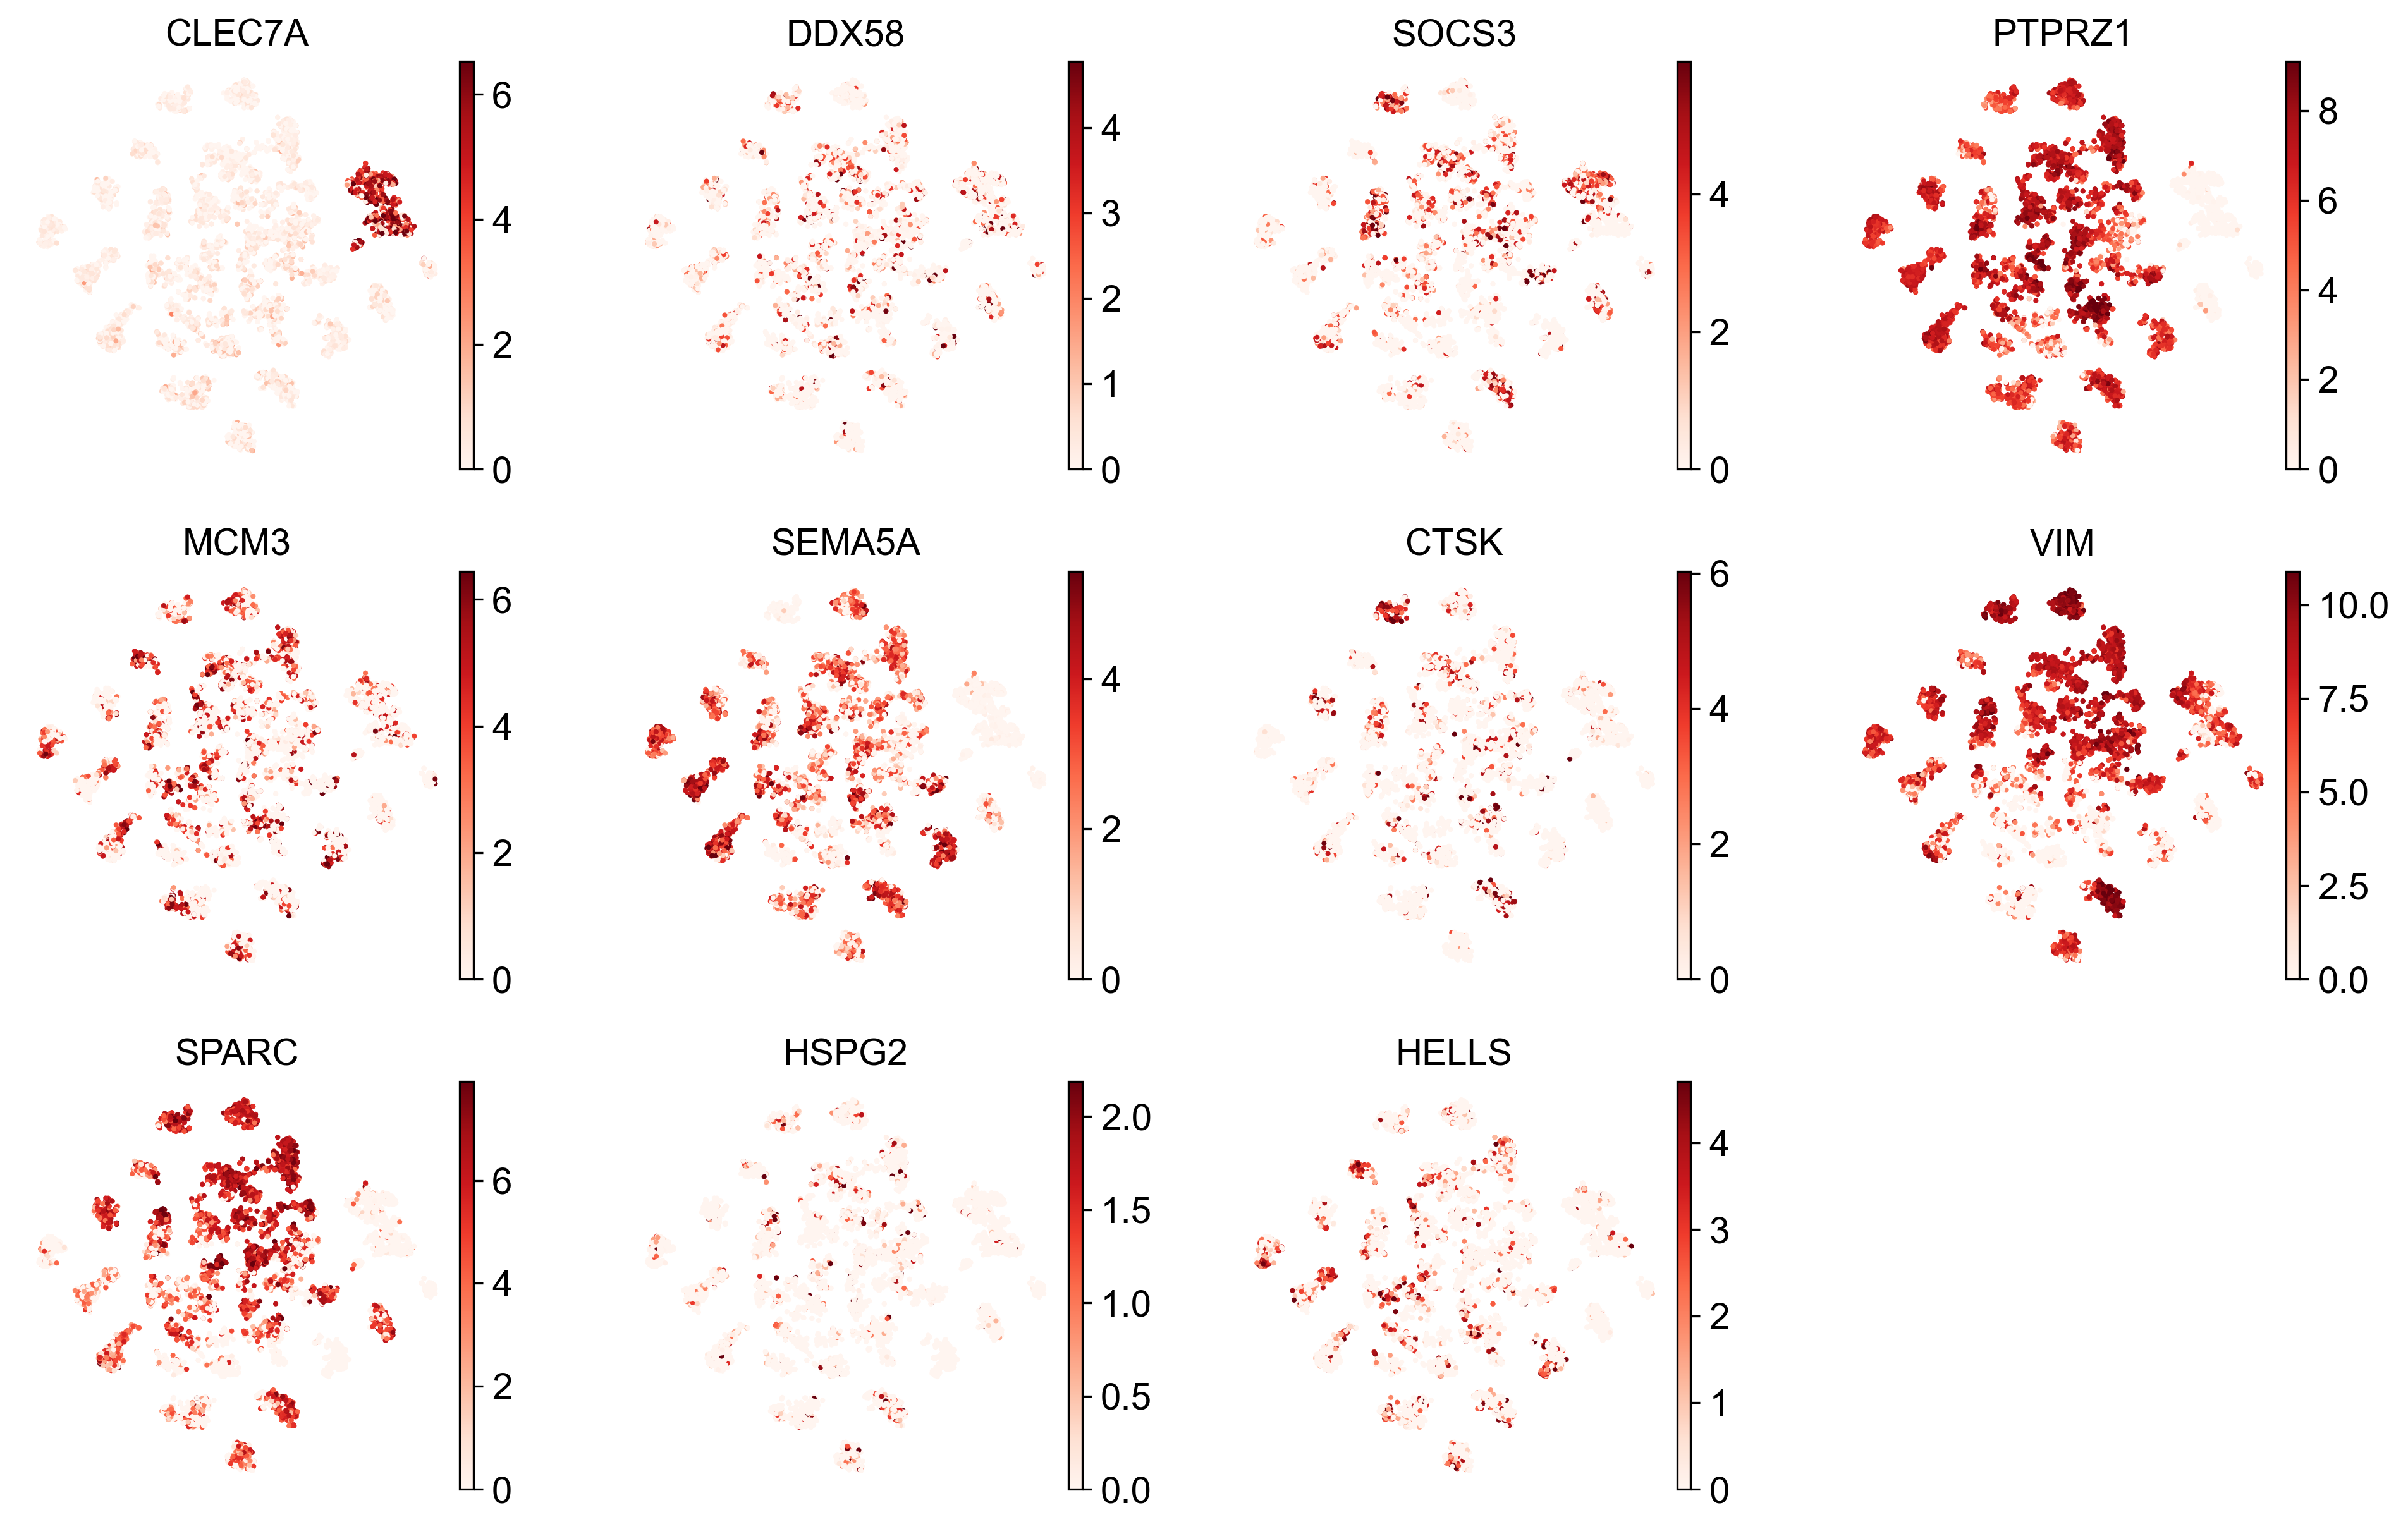





GLIOBLASTOMA NEGATIVE:


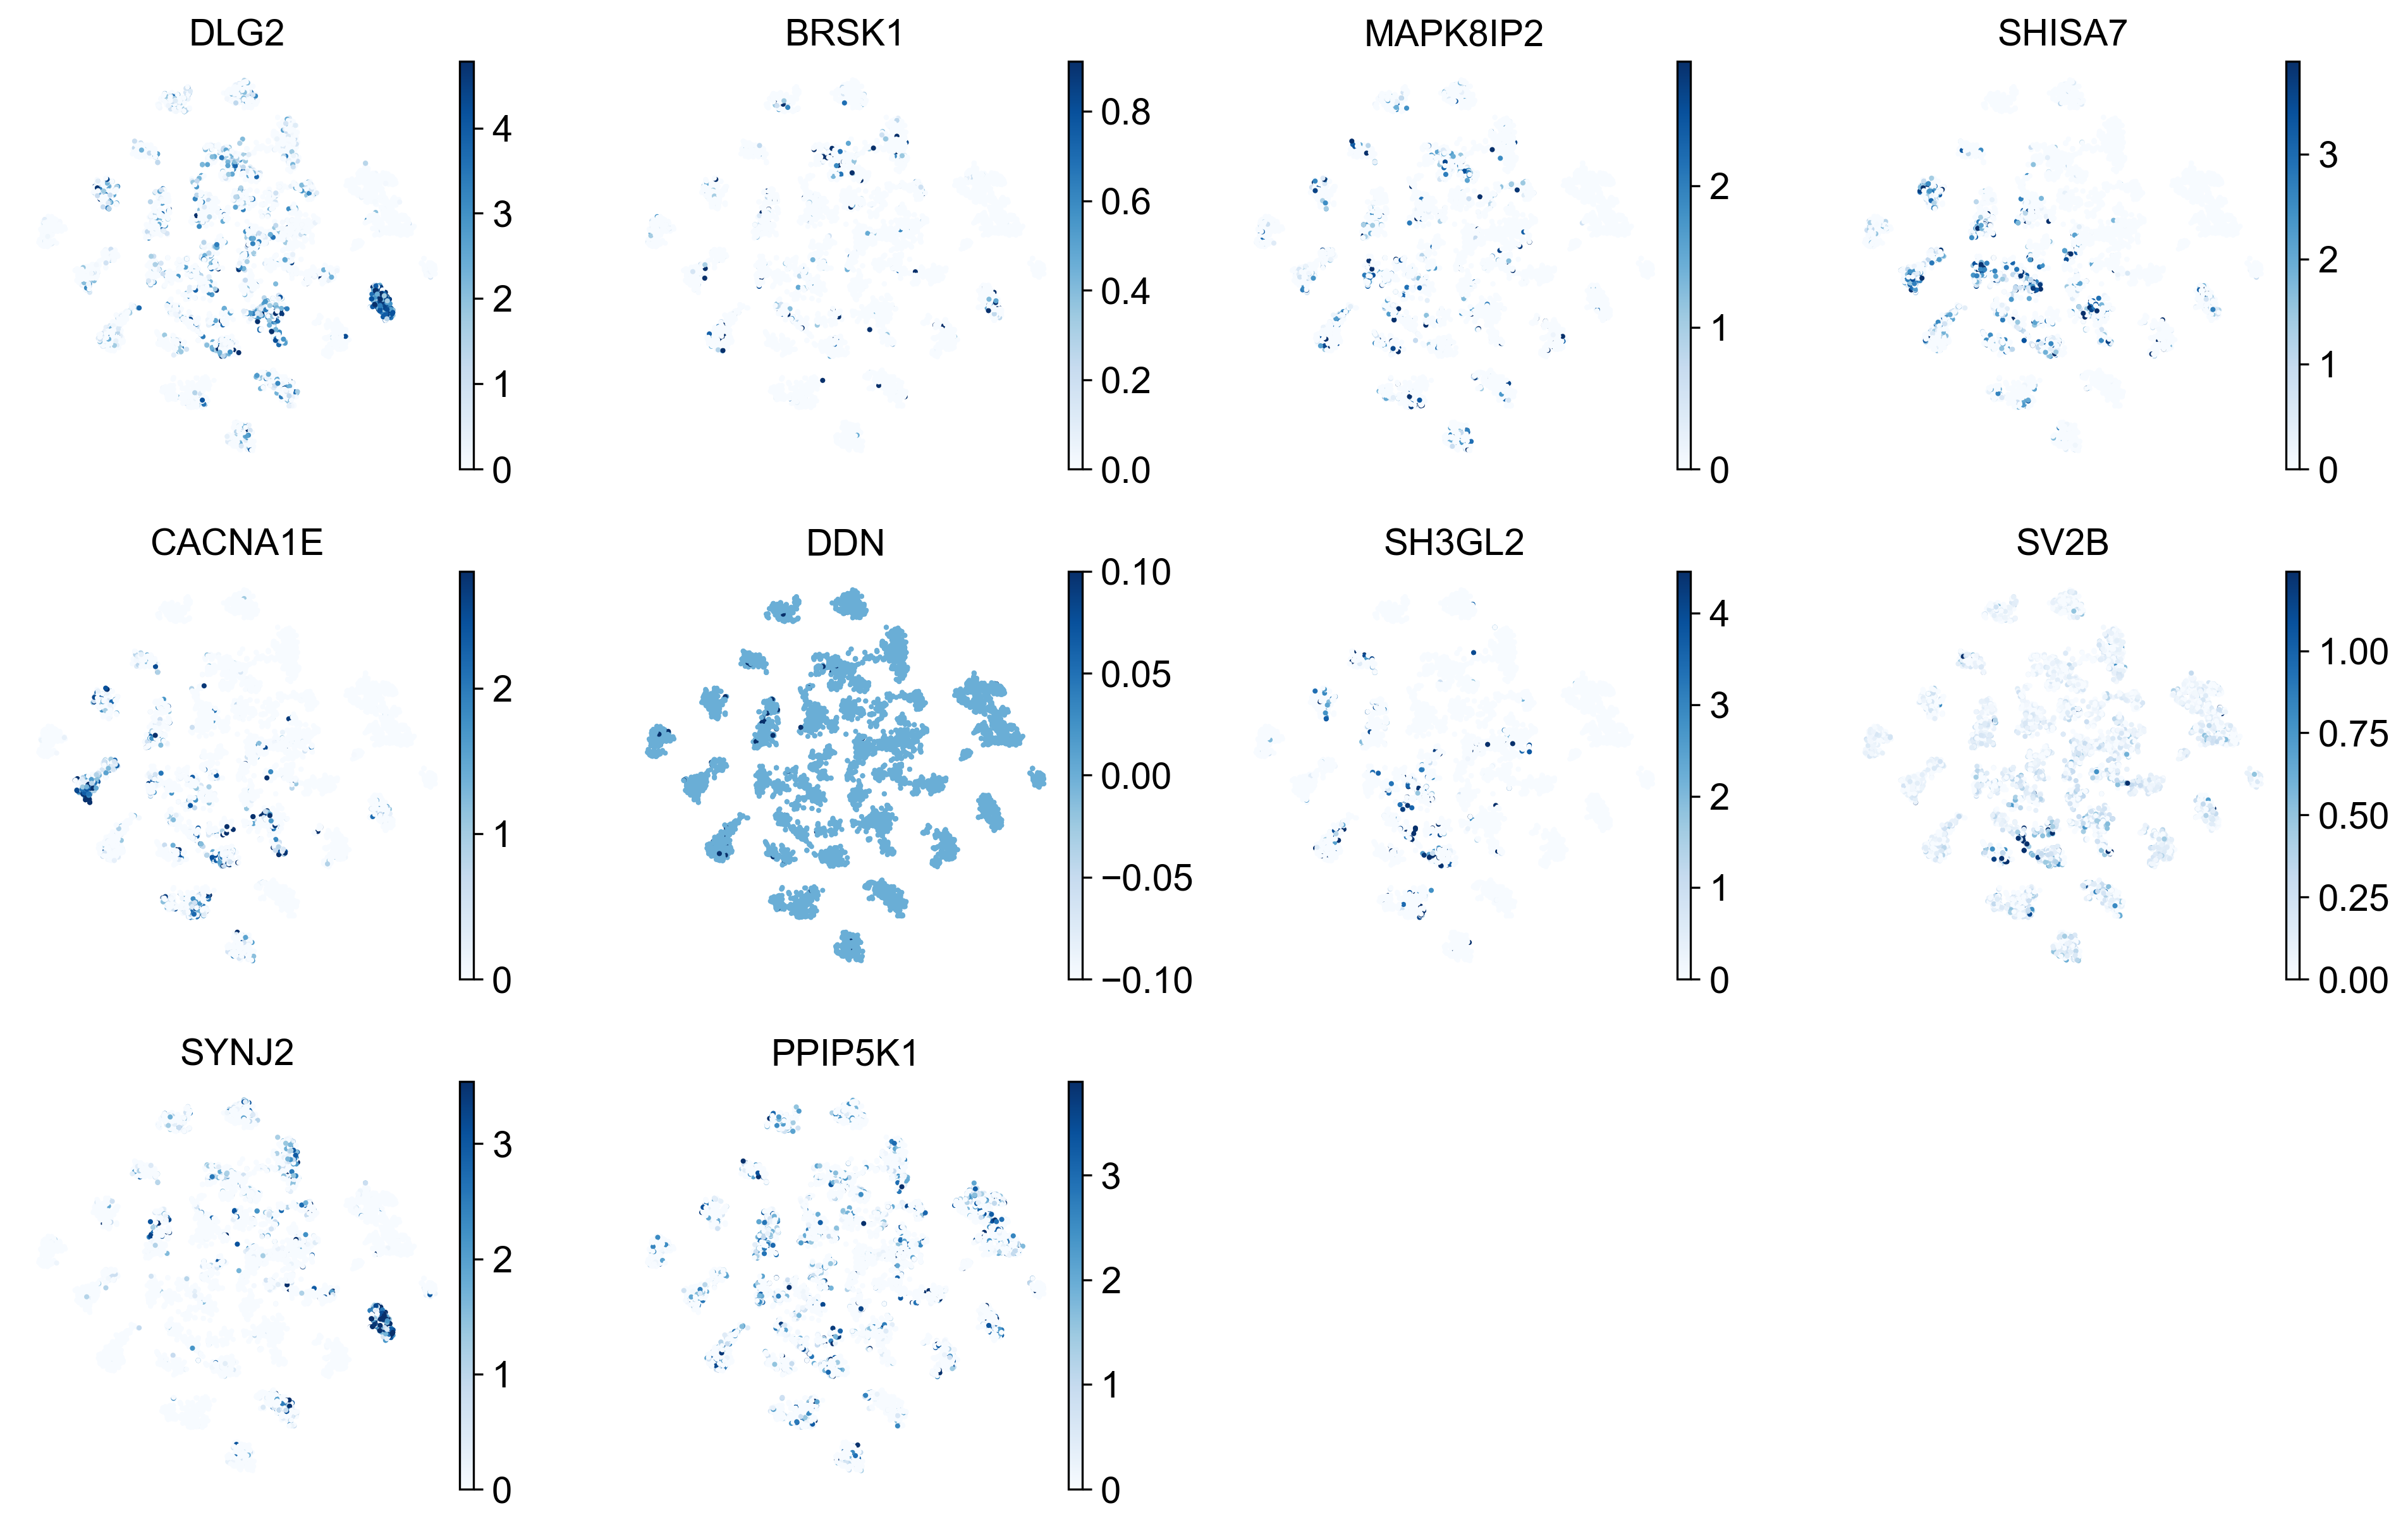

In [9]:
glioblastoma_genes = {
    "Glioblastoma Positive": ["CLEC7A", "DDX58", "SOCS3", "PTPRZ1", "MCM3", "SEMA5A", "CTSK", "VIM", "SPARC", "HSPG2", "HELLS" ],
    "Glioblastoma Negative": ["DLG2", "BRSK1", "MAPK8IP2", "SHISA7", "CACNA1E", "DDN", "SH3GL2", "SV2B", "SYNJ2", "PPIP5K1"]
}

for gg in glioblastoma_genes:
    print(f"{gg.upper()}:")  # print cell subtype name
    cmap = "Reds" if gg == "Glioblastoma Positive" else "Blues"
    sc.pl.tsne(
        adata,
        color=glioblastoma_genes[gg],
        vmin=0,
        vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap=cmap,
    )
    print("\n\n\n")  # print white space for legibility


Now we filter the cells by cell type, according to the paper's methodology. The paper states: "We thus defined sets of marker genes for each of those cell types and scored each cell by their average expression... Cells were classified to each of these cell types by scores above 4."

So we will get the average relative expression of all of the mentioned marker genes per cell type, and then label those with a value greater than 4 as that cell type.

I am also showing the tSNE plot, first labeled by origin and then by identified cell type, showing the clusters appear where we would expect based on the gene expression plots above.

I then also show the UMAP plot, just to verify the cell types are clustered together on that plot as well.

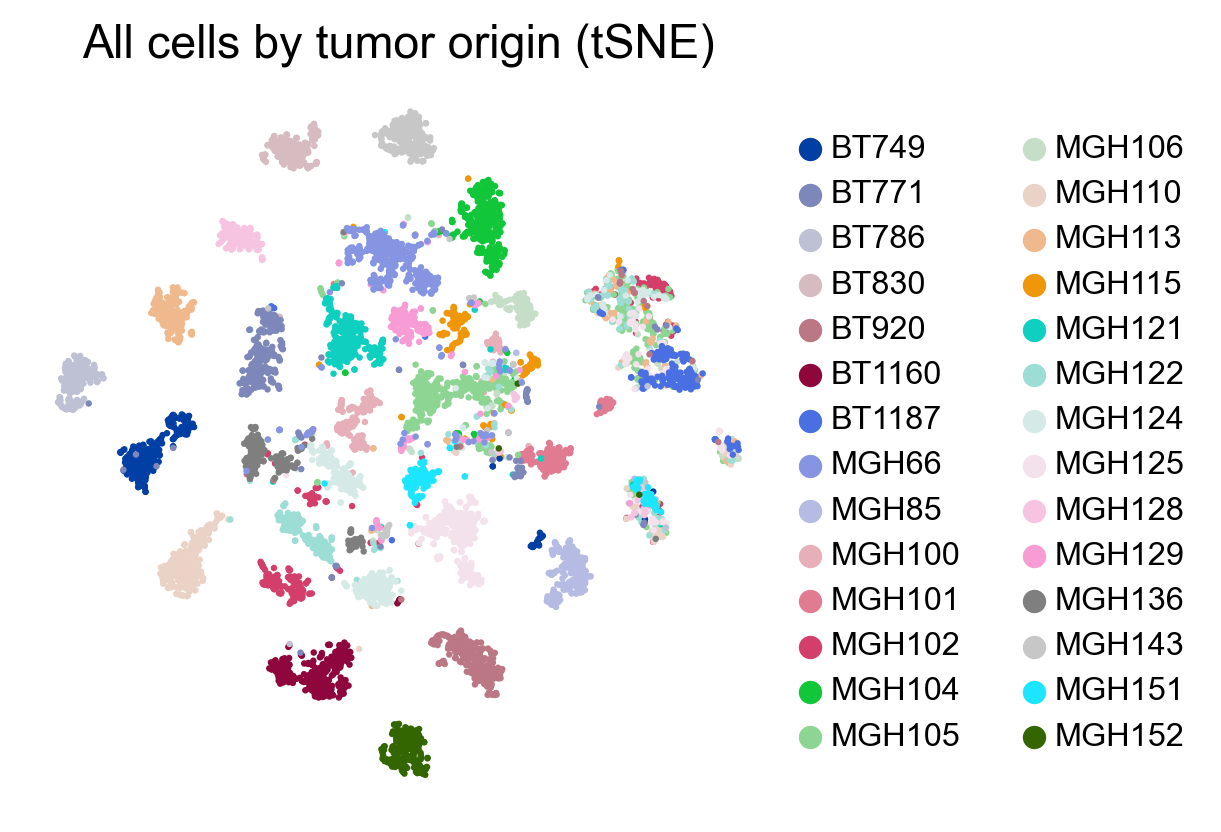

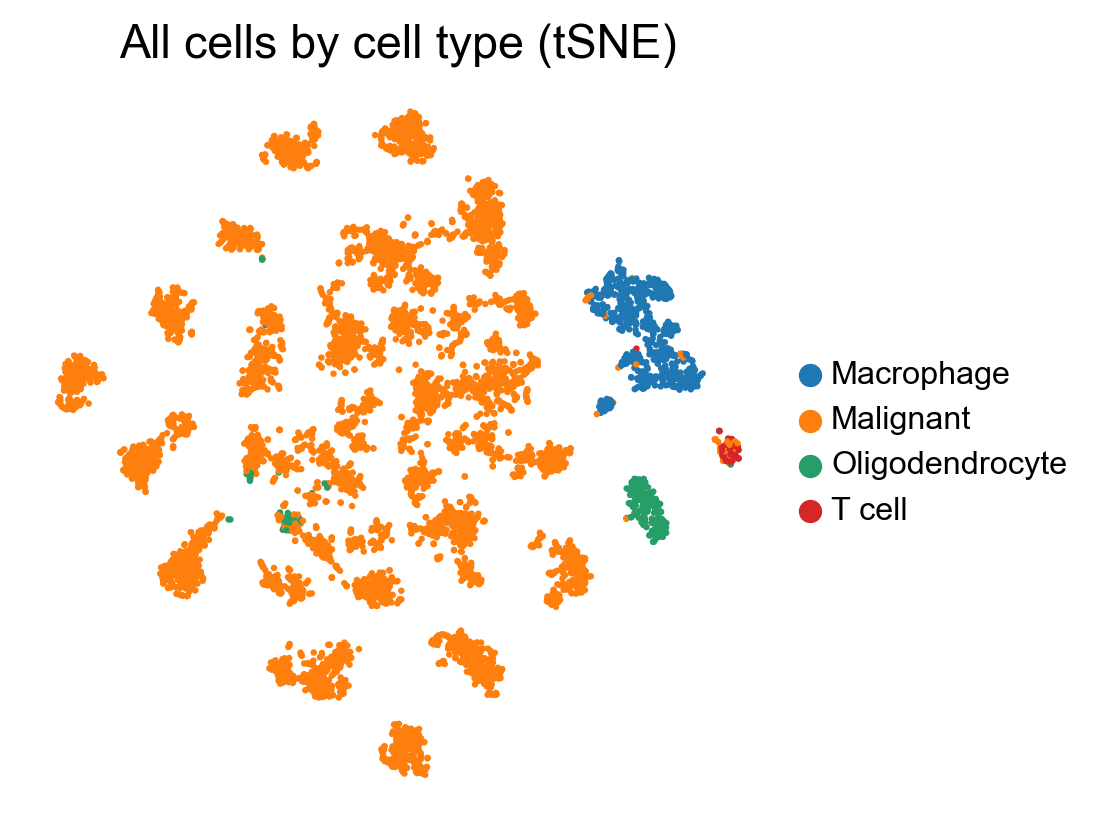

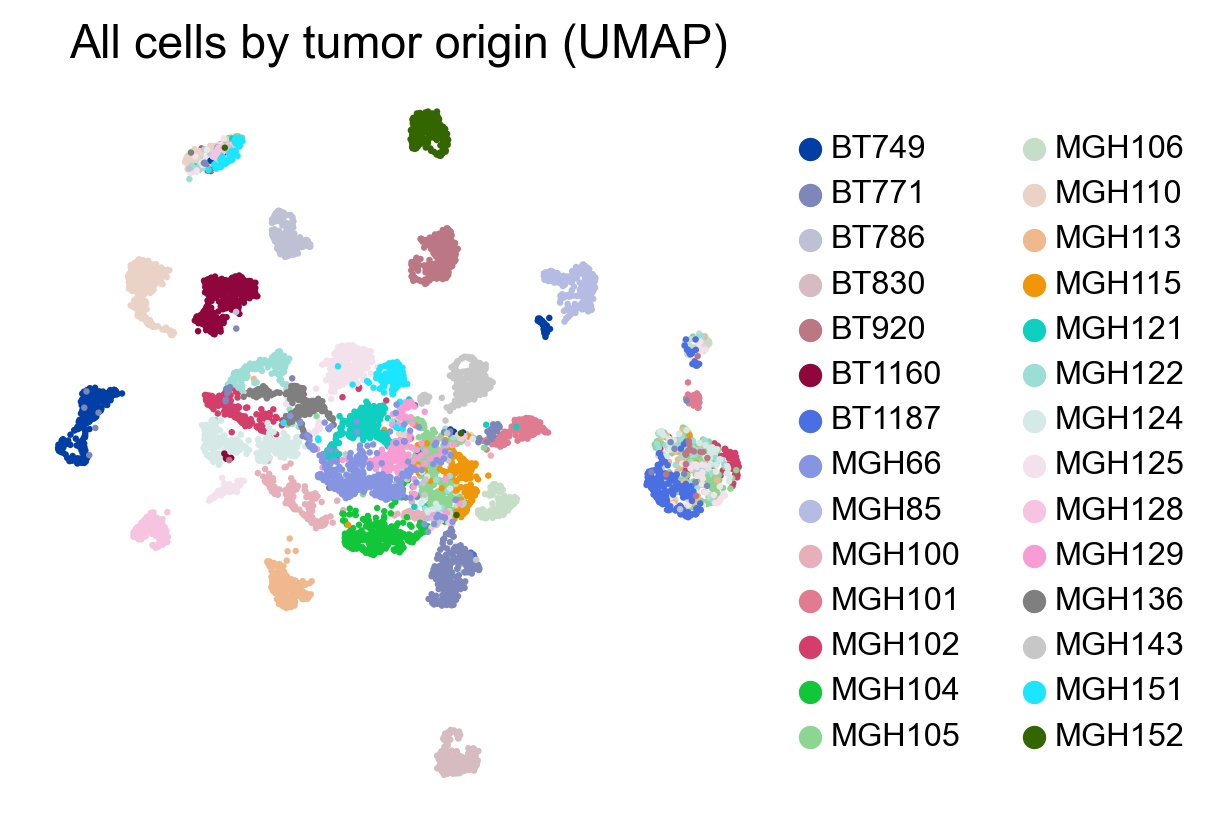

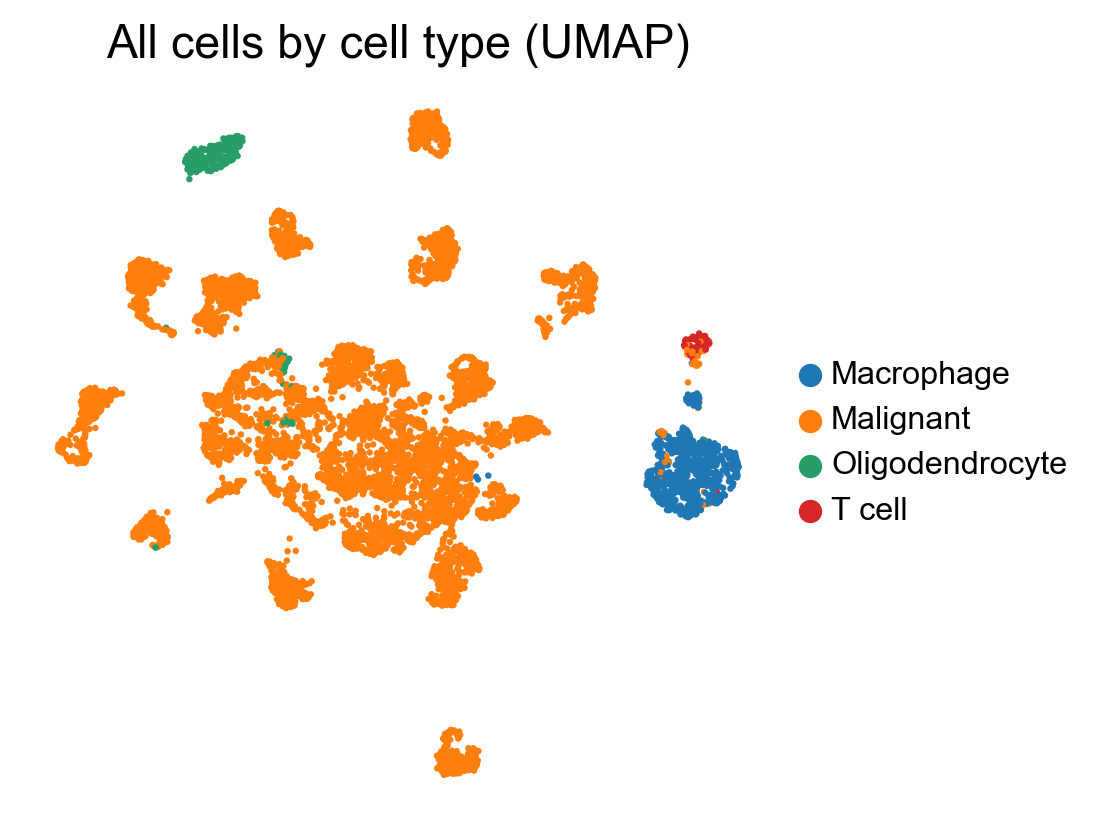

In [10]:
adata.obs["celltype"] = "Malignant"

sc.set_figure_params(dpi=120, frameon=False)

for ct in marker_genes:
    adata.obs["avg_" + ct] = adata[:,marker_genes[ct]].to_df().mean(axis=1)
    cells = adata[(adata.obs["avg_" + ct] > 4),].obs.index
    adata.obs.loc[adata.obs.index.isin(list(cells)), "celltype"] = ct

sc.pl.tsne(adata, color="origin", title="All cells by tumor origin (tSNE)", legend_fontsize="x-small")
sc.pl.tsne(adata, color="celltype", title="All cells by cell type (tSNE)", legend_fontsize="x-small")

sc.pl.umap(adata, color="origin", title="All cells by tumor origin (UMAP)", legend_fontsize="x-small")
sc.pl.umap(adata, color="celltype", title="All cells by cell type (UMAP)", legend_fontsize="x-small")

sc.set_figure_params(dpi=150, frameon=False)

Now we will keep only the cells identified as malignant, resulting in a total of 6860 cells remaining. We then recalculate the QC metrics, the PCs, and the tSNE plot, showing the tSNE plot with just the malignant cells (comparable to Figure 1C in the paper).

In [11]:
adata = adata[adata.obs["celltype"] == "Malignant",:]
adata

View of AnnData object with n_obs × n_vars = 6860 × 23686
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'origin', 'celltype', 'avg_Macrophage', 'avg_T cell', 'avg_Oligodendrocyte'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'tsne', 'neighbors', 'umap', 'origin_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

C:\Users\Andrew\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


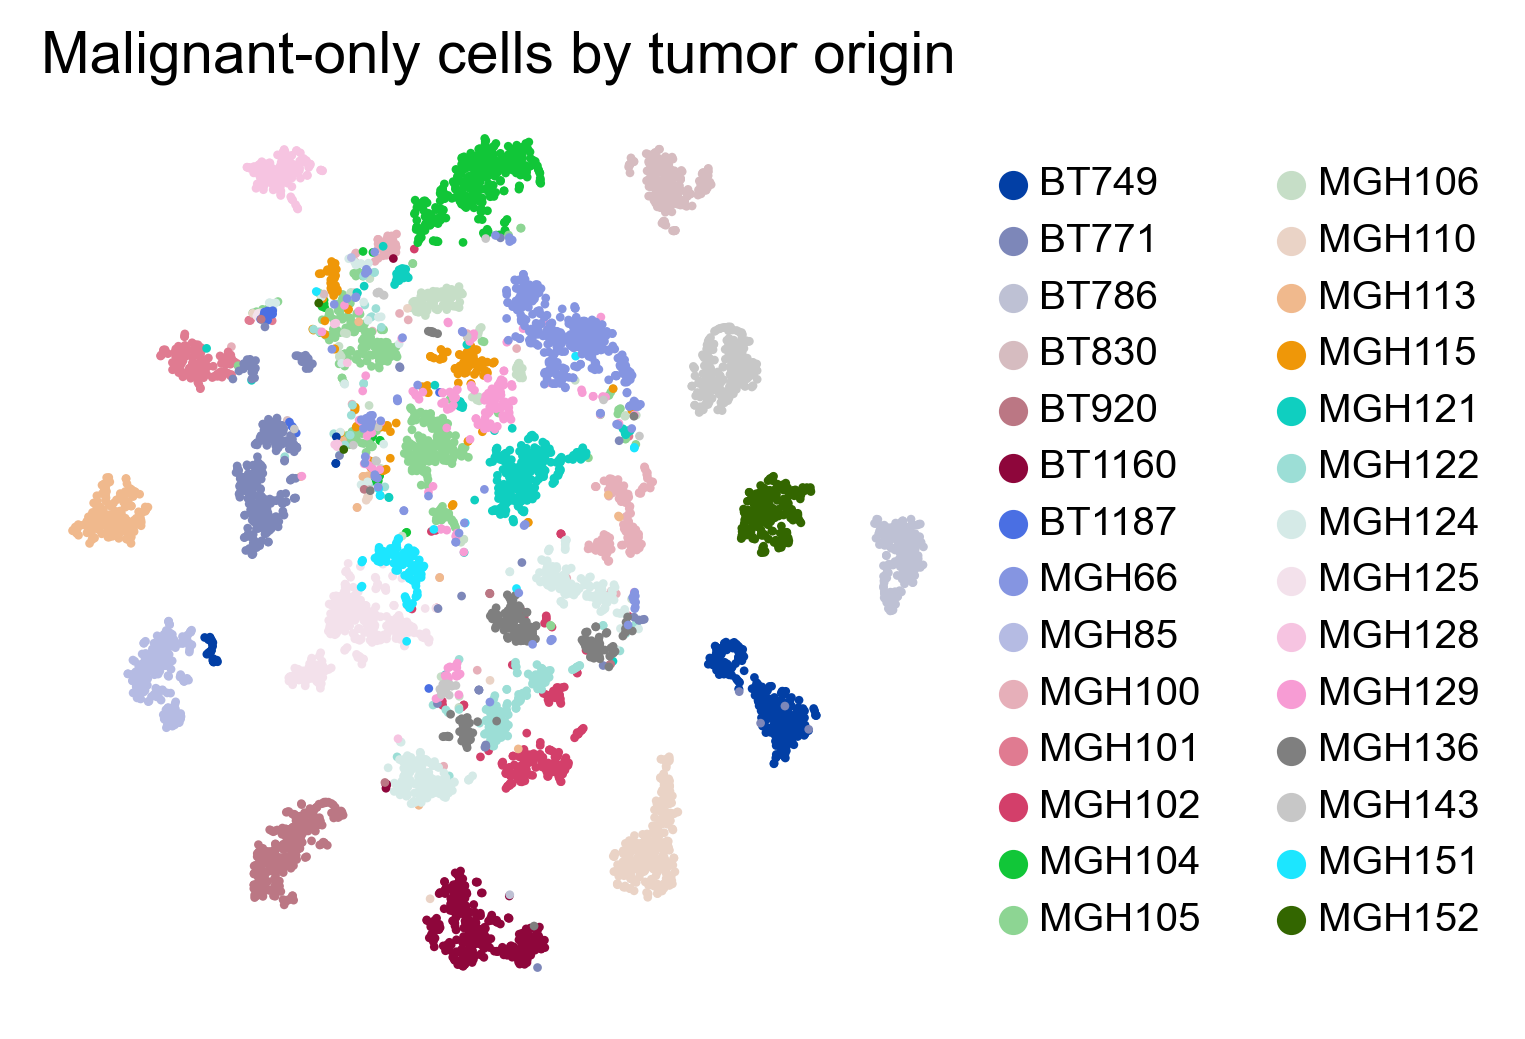

In [12]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.pca(adata, svd_solver="arpack")
sc.tl.tsne(adata, use_rep="X_pca", n_pcs=30)
sc.pl.tsne(adata, color="origin", title="Malignant-only cells by tumor origin", legend_fontsize="x-small")

### Defining single-cell gene signature scores

I don't think there is enough information provided in the methods section of this paper to re-create this portion. They do not state what gene sets they are using for this. The Results section mentions "high expression of gene sets corresponding to markers of particular cell types classified some of the cells as macrophages, T cells, and oligodendrocytes", which I think indicates that they took the "gene signature" scores and then used them to make those gene marker sets they used to identify malignant cells based on the clustering, but I am unable to reproduce this right now.

### CNA inference

They mentioned how they did it, but did not mention any programs. However, I was able to find a GitHub repository for the R package `infercna` by one of the authors, J. Laffy.

In trying to install infercna, I am finding that it will not work on the latest version of R, as I am unable to install its prerequisite, `scalop`, also by J. Laffy.

I would install an older version of R to be able to perform this analysis, but that is beyond the scope of my learning process right now.

### Final cells from the SMART-Seq2 dataset

Based on just using the gene marker sets for macrophages, oligodendrocytes, and T cells, we are able to identify 6860 malignant cells.

The paper reports that they had 6864 malignant cells. This indicates that their CNA analysis identified 4 cells as malignant that were identified as non-malignant cells above.

I am saving this AnnData file to be used in Part 2.

In [13]:
adata.write("neftel_smartseq2_malignant.h5ad")